# TVB Reduced Wong-Wang with Feedback Inhibition Control

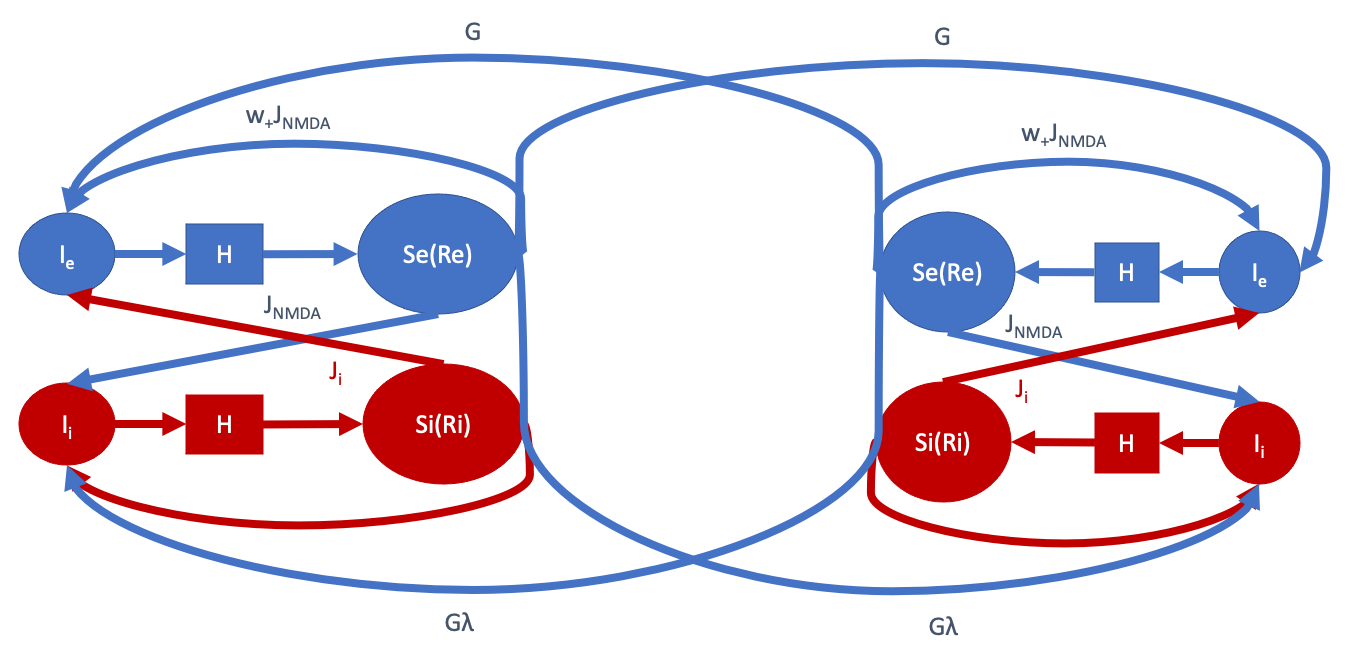

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./RedWongWang.png',  width=1000, unconfined=False))

## Reduced Wong-Wang mean field model with 1 Excitatory and 1 Inhibitory population and Feedback Inhibition Control

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}}^{(E)} = - \frac{1}{\tau_E}{S_{n\prime}}^{(E)}(t) + (1-{S_{n\prime}}^{(E)}(t))\gamma_{E} {R_{n\prime}}^{(E)}(t)$

$\dot{S_{n\prime}}^{(I)} = - \frac{1}{\tau_I}{S_{n\prime}}^{(I)}(t) + \gamma_I{R_{n\prime}}^{(I)}(t)$

to which we add the FIC dynamics:

$\dot{J_{n\prime}}^{(I)} = \eta {J_{n\prime}}^{(I)}(t)  {S_{n\prime}}^{(I)}(t) ({R_{n\prime}}^{(E)}(t) - {R_{0}}^{(E)})$

with the alternative choices:

$\dot{J_{n\prime}}^{(I)} = \eta {S_{n\prime}}^{(I)}(t) ({R_{n\prime}}^{(E)}(t) - {R_{0}}^{(E)})$

$\dot{J_{n\prime}}^{(I)} = \eta {R_{n\prime}}^{(I)}(t)({R_{n\prime}}^{(E)}(t) - {R_{0}}^{(E)})$

$\dot{J_{n\prime}}^{(I)} = \eta ({R_{n\prime}}^{(E)}(t) - {R_{0}}^{(E)})$


where we bound ${S_{n\prime}}^{(E/I)}(t) \in $ [0.0, 1.0], 

and $ {R_{n\prime}}^{(E/I)}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}^{(E/I)}(t) = H({I_{syn_{n\prime}}}^{(E/I)}(t), a_{(E/I)}, b_{(E/I)}, d_{(E/I)}) $

where

$ H({I_{syn_{n\prime}}}^{(E/I)}(t),  a_{(E/I)}, b_{(E/I)}, d_{(E/I)}) = \frac{a_{(E/I)}{I_{syn_{n\prime}}}^{(E/I)}(t)-b_{(E/I)}}{1-e^{-d_{(E/I)}(a_{(E/I)}{I_{syn_{n\prime}}}^{(E/I)}(t)-b_{(E/I)})}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}^{(E)}(t) = W_EI_o + w_+J_{NMDA}{S_{n\prime}}^{(E)}(t) - {J_{n\prime}}^{(I)}(t){S_{n\prime}}^{(I)}(t) + GJ_{NMDA}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}^{(E)}(t-\tau_{{m\prime}{n\prime}})$

and to inhibitory ones:

$ {I_{syn_{n\prime}}}^{(I)}(t) = W_II_o + J_{NMDA}{S_{n\prime}}^{(E)}(t) - {S_{n\prime}}^{(I)}(t) +  \lambda GJ_{NMDA}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}^{(E)}(t-\tau_{{m\prime}{n\prime}})$

where 
$\lambda  \in$[0, 1] for scaling feedforward inhibition.

TVB connectivity weights $C_{{m\prime}{n\prime}}$ are scaled per "region"

## Reduced Wong-Wang mean field model

## Parameters following Ponce-Alvarez et al 2014:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.382nA$ 
- excitatory synaptic coupling $J_{NDMA} = 0.15nA$ 
- local feedback inhibitory synaptic coupling initial condition $J_{i} = 1.0nA$ 
- local excitatory recurrence $w_+ = 1.4$
- excitatory kinetic parameter $\gamma_E = 0.641 s$
- inhibitory kinetic parameter $\gamma_I = 1.0 s$
- excitatory (NMDA) time constant $\tau_E = \tau_{NMDA}=100ms$ 
- inhibitory (GABA) time constant $\tau_I = \tau_{GABA}=10ms$ 
- excitatory pool scaling constant $W_E = 1.0$
- inhibitory pool scaling constant $W_I = 0.7$
- excitatory sigmoidal functions parameters $a_{E} = 310nC^{-1}$, $b_{E} = 125Hz$, $d_{E} = 0.16s$
- inhibitory sigmoidal functions parameters $a_{I} = 615nC^{-1}$, $b_{I} = 177Hz$, $d_{I} = 0.087s$
- $\lambda \in [0.0, 1.0]$, allowing for feedforward inhibition
- $\eta << 0.01 $, the adaptation rate of Feedback Inhibition Control
- ${R_{0}}^{(E)} = 3.06 $, the target rate of the excitatory population for Feedback Inhibition Control


In [2]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)
    
# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Prepare TVB simulator <br> (including structural data -minimally a TVB connectivity, region mean field model, integrator, monitors etc)

/Users/dionperd/opt/anaconda3/lib/python3.7/site-packages/tvb_library-2.6-py3.7.egg/tvb/simulator/plot/base_plotter.py:62: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


(<Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':'Connectivity'}>,
 <Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':"Tracts' lengths"}>)

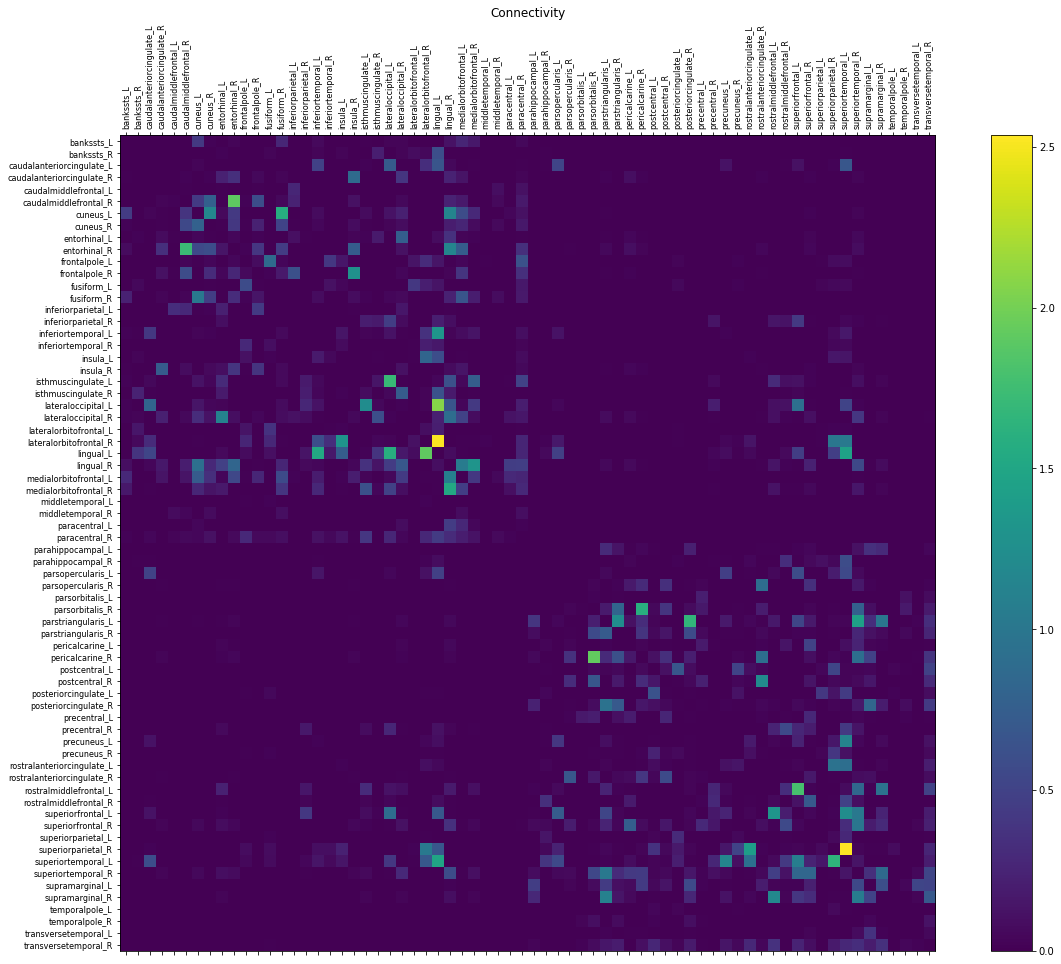

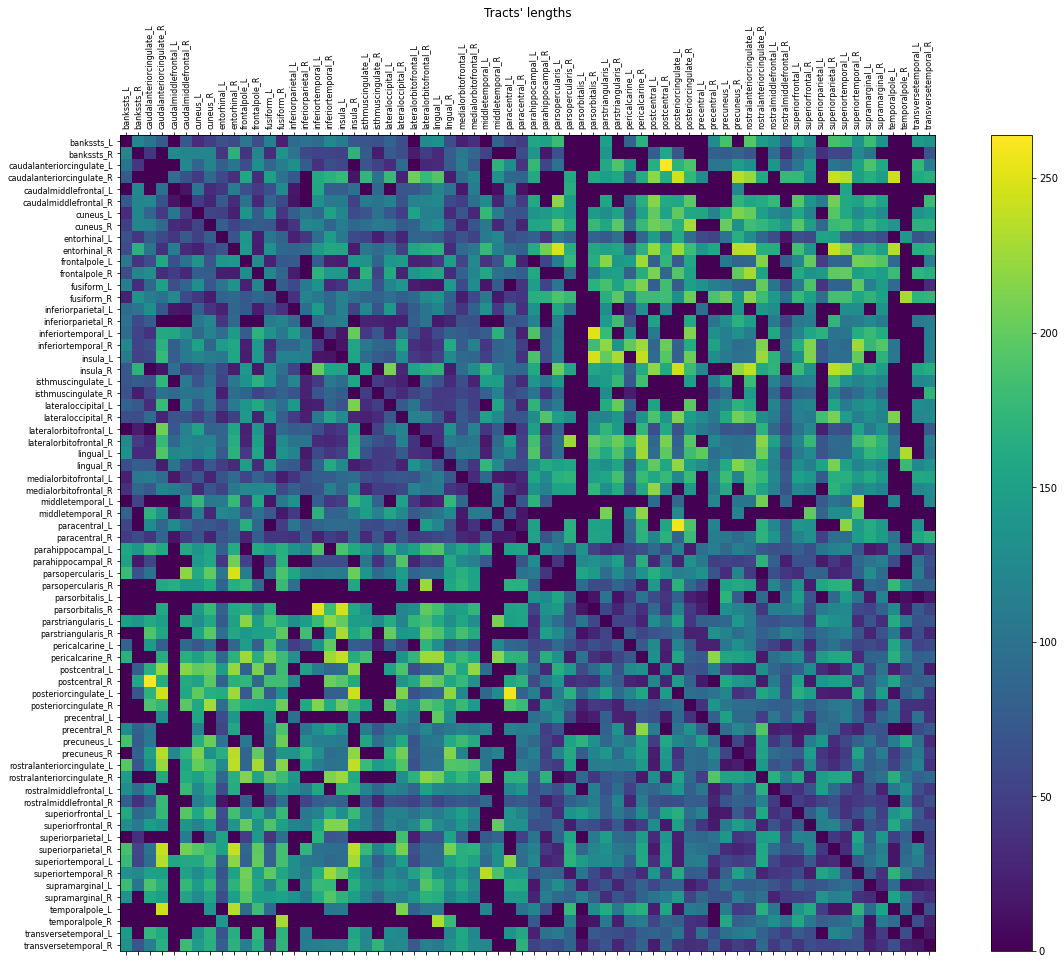

In [3]:
from tvb.simulator.simulator import Simulator
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.integrators import EulerStochastic
from tvb.simulator.monitors import TemporalAverage
from tvb.contrib.simulator.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhIFIC
from tvb.simulator.plot.config import CONFIGURED
from tvb.simulator.plot.plotter import Plotter


# Given that tau_e = 100.0 and tau_i = 10.0:
# - eta should much smaller than 0.01, e.g., maybe 0.001
# - we can have a large time step, i.e., dt = 1.0 ms.

simulator = Simulator()

# Set here the path to your data:
TVB_DATA_PATH = "/Users/dionperd/Software/TVB/tvb-multiscale/examples/data/tvb_data"
DEFAULT_SUBJECT_PATH = os.path.join(TVB_DATA_PATH, "berlinSubjects", "QL_20120814")
DEFAULT_CONNECTIVITY_ZIP = os.path.join(DEFAULT_SUBJECT_PATH, "QL_20120814_Connectivity.zip")
simulator.connectivity = Connectivity.from_file(DEFAULT_CONNECTIVITY_ZIP)
simulator.connectivity.configure()
simulator.connectivity.weights /= np.percentile(simulator.connectivity.weights, 99)
n_regions = simulator.connectivity.number_of_regions

simulator.model = ReducedWongWangExcIOInhIFIC(G=np.array([100.0]),
                                              J_i=np.ones((n_regions,)),
                                              lamda=np.array([0.0]),
                                              eta=np.array([0.001]), 
                                              R_e_0=np.array([3.06]))

# Set
# FIC = 0 for simulation without FIC, i.e, with J_i(t) set to the J_i parameter
# FIC = 1, for dJ_i/dt = eta * (R_e(t) - R_e_0)
# FIC = "R", for dJ_i/dt = eta * R_i(t) * (R_e(t) - R_e_0)
# FIC = "S", for dJ_i/dt = eta * S_i(t) * (R_e(t) - R_e_0)
# FIC = "JS", for dJ_i/dt = eta * J_i(t) * S_i(t) * (R_e(t) - R_e_0)
simulator.model.FIC = "R"

simulator.model.use_numba = True
simulator.model.configure()

simulator.integrator = EulerStochastic(dt=1.0)  # - we can have a large time step, i.e., dt = 1.0 ms.
# State variables: [S_e, S_i, J_i, R_e, R_i], the first three are integrated, the last two intermediate quantities
# Only the integrated ones could have some noise:
simulator.integrator.noise.nsig = np.array([1e-6]*3 + [0.0]*2)  # zero noise for bifurcation analysis!

simulator.initial_conditions = np.random.uniform(size=(1000, simulator.model.nvar, n_regions, 1))
# Set J_i to 1.0 for the initial condition, e.g., equal to the J_i parameter

simulator.initial_conditions[:, 2, :, 0] = np.repeat(simulator.model.J_i[np.newaxis], 1000, axis=0)

simulation_length = 25000.0

simulator.monitors = (TemporalAverage(period=1.0),)

simulator.configure()

CONFIGURED.SHOW_FLAG = True
plotter = Plotter(CONFIGURED)
plotter.plot_tvb_connectivity(simulator.connectivity)


## 2. Configure simulator, simulate, gather results

In [4]:
# Simulate!
t = time.time()
results = simulator.run(simulation_length=simulation_length)
print("\nSimulated in %f secs!" % (time.time() - t))


Simulated in 19.215163 secs!


In [5]:
# Gather the results
t = results[0][0]
source = results[0][1]

# Put the results in a Timeseries instance
from tvb.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesRegion(data=source, time=t, 
                             connectivity=simulator.connectivity,
                             labels_ordering=["Time", "State Variable", "Region", "Neurons"],
                             labels_dimensions=
                             {"State Variable": simulator.model.state_variables,
                              "Region": simulator.connectivity.region_labels.tolist()},
                             sample_period=simulator.integrator.dt)
source_ts.configure()

source_ts 


,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,25000.0
Region Mapping,None
Region Mapping Volume,None
Sample period,1.0
Source Connectivity,Connectivity gid: 35299728-7d5b-4120-b5db-03f2c3f09309
Start time,0
Time units,ms
Time-series name,TimeSeriesRegion gid: 24fe6e07-fd5d-4b67-a551-ec3054f6cb32
Time-series type,TimeSeriesRegion


In [25]:
print("Last second R_e(t):\nmean = %g\nstd = %g\nmin = %g\nmax = %g" % 
      (source_ts.data[-1000:, 3].mean(), source_ts.data[-1000:, 3].std(), 
       source_ts.data[-1000:, 3].min(), source_ts.data[-1000:, 3].max()))


Last second R_e(t):
mean = 3.03064
std = 0.429853
min = 0.960257
max = 6.13771


### Interactive time series plot

In [7]:
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)


/Users/dionperd/opt/anaconda3/lib/python3.7/site-packages/tvb_library-2.6-py3.7.egg/tvb/simulator/plot/base_plotter.py:62: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


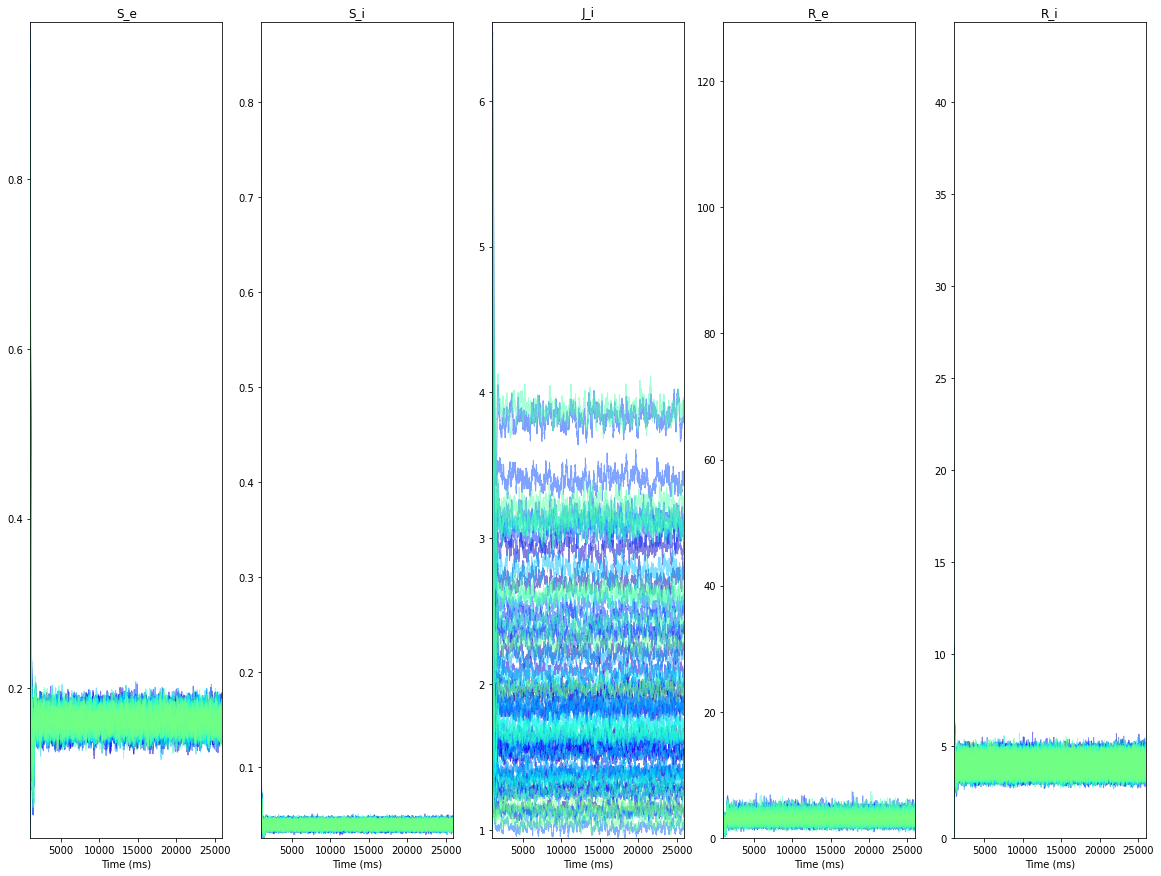

In [8]:
# For raster plot:
fig, axes, lines = plotter.plot_tvb_timeseries(source_ts)


/Users/dionperd/opt/anaconda3/lib/python3.7/site-packages/tvb_library-2.6-py3.7.egg/tvb/simulator/plot/base_plotter.py:62: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


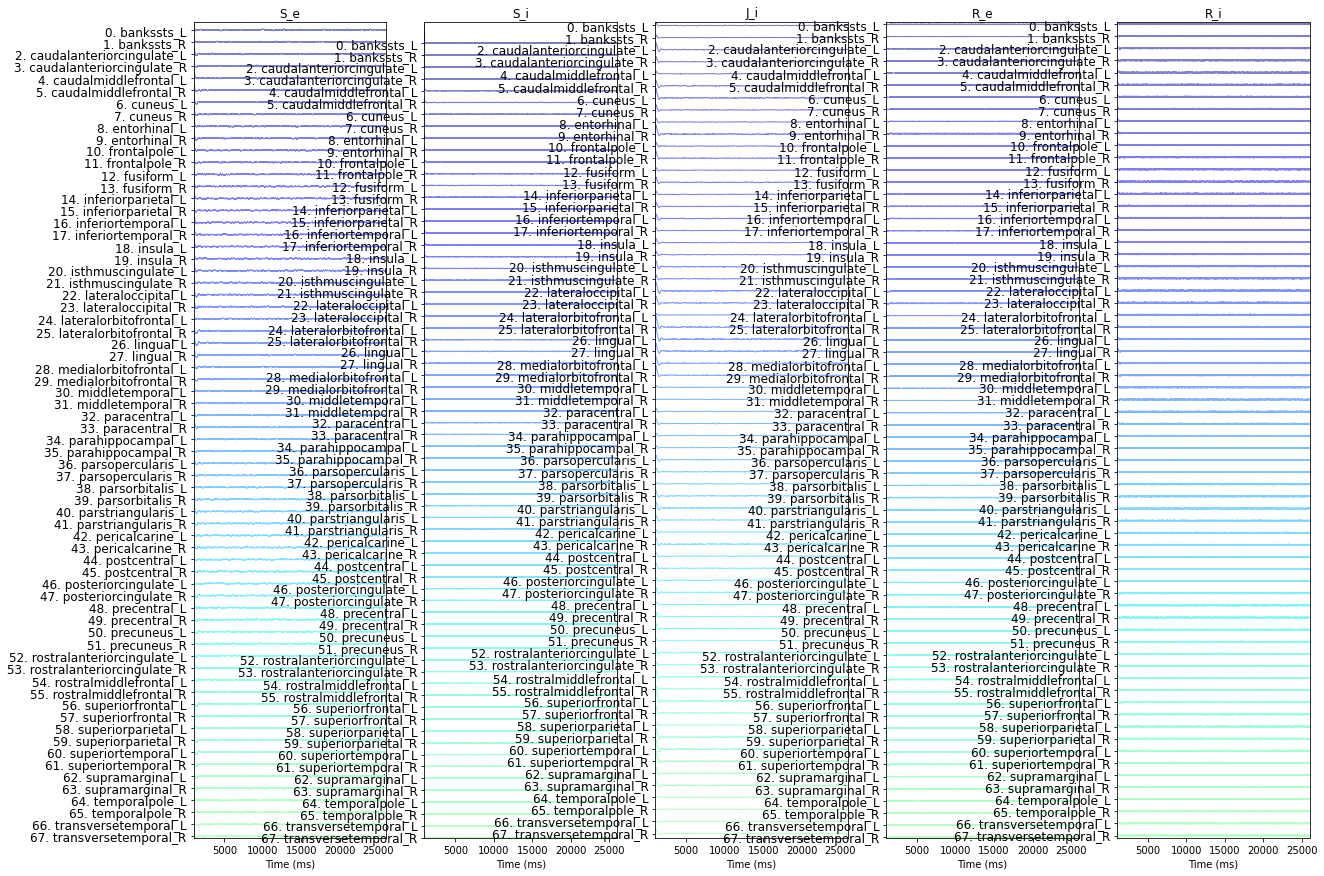

In [9]:
plotter.plot_raster(source_ts)
    

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>
   
3 Deco Gustavo, Ponce-Alvarez Adrian, Patric Hagmann, <br>
  Gian Luca Romani, Dante Mantini,and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 34(23), 7886-7898, 2014.<br>
  
4 Deco Gustavo, Ponce-Alvarez Adrian, Dante Mantini,<br>
  Gian Luca Romani, Patric Hagmann, and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 33(27), 11239-11252, 2013.<br>

5 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>